# Montgomery County Collision Analysis

## Introduction
<br>We will be examining traffic collisions that occurred in Montgomery County, Maryland. Our data set has over fifteen thousand collision reports based on preliminary data. The data set includes columns such as the time of day that the crash occurred, the vehicle's impact locations, and the vehicle's movement at the time of the collision. We will be using this data to see what aspects of a crash lead to lower or higher rates of injury severity. Therefore, we are most interested in the correlation of 'Injury Severity', 'Vehicle Body Type', and 'Vehicle Movement' and others. We will create new columns based on factors that are most apparent to our exploration of the data.

In [1]:
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency

import warnings
warnings.filterwarnings('ignore')

## Data Exploration
Let us explore our data now.

In [2]:
df_county = pd.read_csv('data/Crash_Reporting_-_Drivers_Data.csv')
df_state = pd.read_csv('data/Maryland_Statewide_Vehicle_Crashes.csv')
df_nonmotor = pd.read_csv('data/Crash_Reporting_-_Non-Motorists_Data.csv')

In [3]:
county_df = df_county.copy()
non_motorist_df = df_nonmotor.copy()
county_reduced_df = county_df[['Report Number','Local Case Number','ACRS Report Type','Related Non-Motorist','Driver Substance Abuse','Non-Motorist Substance Abuse','Driver At Fault','Injury Severity','Circumstance','Driver Distracted By','Speed Limit']]
non_motorist_reduced_df = non_motorist_df[['Report Number','Local Case Number','Pedestrian Type','Pedestrian Movement','Pedestrian Actions','Pedestrian Location','Pedestrian Obeyed Traffic Signal','Pedestrian Visibility','At Fault']]
# Add columns to a new DataFrame for all visualizations

driver_distraction_df = pd.merge(county_reduced_df,non_motorist_reduced_df,on=['Report Number','Local Case Number'])
driver_distraction_df = driver_distraction_df.rename(columns={'At Fault':'Pedestrian At Fault'})

In [4]:
df_county['Crash Date/Time'] = pd.to_datetime(df_county['Crash Date/Time'])
df_county['YEAR'] = df_county['Crash Date/Time'].dt.year
df_county['MONTH'] = df_county['Crash Date/Time'].dt.month

In [5]:
df_state.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 878343 entries, 0 to 878342
Data columns (total 55 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   YEAR                   878343 non-null  int64  
 1   QUARTER                878343 non-null  object 
 2   LIGHT_DESC             841025 non-null  object 
 3   LIGHT_CODE             878343 non-null  float64
 4   COUNTY_DESC            878329 non-null  object 
 5   COUNTY_NO              878329 non-null  float64
 6   MUNI_DESC              0 non-null       float64
 7   MUNI_CODE              659957 non-null  float64
 8   JUNCTION_DESC          760119 non-null  object 
 9   JUNCTION_CODE          791512 non-null  float64
 10  COLLISION_TYPE_DESC    878343 non-null  object 
 11  COLLISION_TYPE_CODE    878343 non-null  int64  
 12  SURF_COND_DESC         789107 non-null  object 
 13  SURF_COND_CODE         791512 non-null  float64
 14  LANE_CODE              668083 non-nu

## Data Cleaning
<br>
Let us now drop columns that are missing more than 10% of values on average

In [6]:
df_county.drop(columns=df_county.columns[df_county.isna().mean() >= .1], inplace=True)

In [7]:
# Merge the two dataframes with the values that do not already exist in the county data
df_county = pd.merge(left=df_county, right=df_nonmotor[~df_nonmotor['Report Number'].isin(df_county['Report Number'])], on='Report Number', how='left')

Let us overwrite the state DataFrame with only the columns that we would like to analyze.

In [8]:
df_state = df_state[[  'YEAR', 'LIGHT_DESC', 'COUNTY_DESC',
                       'COLLISION_TYPE_DESC', 'WEATHER_DESC',
                       'REPORT_NO', 'WEATHER_CODE', 'ACC_DATE',
                       'LATITUDE', 'LONGITUDE', 'LOCATION']]
df_state.isna().sum()

YEAR                        0
LIGHT_DESC              37318
COUNTY_DESC                14
COLLISION_TYPE_DESC         0
WEATHER_DESC           427866
REPORT_NO                   0
WEATHER_CODE                0
ACC_DATE                    0
LATITUDE                    0
LONGITUDE                   0
LOCATION                    0
dtype: int64

In [9]:
df_state['LIGHT_DESC'] = df_state['LIGHT_DESC'].fillna(df_state['LIGHT_DESC'].value_counts().index[0])
df_state['COUNTY_DESC'] = df_state['COUNTY_DESC'].fillna('NA')

In [10]:
df_state.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 878343 entries, 0 to 878342
Data columns (total 11 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   YEAR                 878343 non-null  int64  
 1   LIGHT_DESC           878343 non-null  object 
 2   COUNTY_DESC          878343 non-null  object 
 3   COLLISION_TYPE_DESC  878343 non-null  object 
 4   WEATHER_DESC         450477 non-null  object 
 5   REPORT_NO            878343 non-null  object 
 6   WEATHER_CODE         878343 non-null  float64
 7   ACC_DATE             878343 non-null  int64  
 8   LATITUDE             878343 non-null  float64
 9   LONGITUDE            878343 non-null  float64
 10  LOCATION             878343 non-null  object 
dtypes: float64(3), int64(2), object(6)
memory usage: 73.7+ MB


Let us clean the Vehicle Body Type column so that the categories are more apparent.

In [11]:
df_county['Simple Vehicle Body Type'] = df_county['Vehicle Body Type'].replace({'TRANSIT BUS':"BUS", "SCHOOL BUS": "BUS", "(SPORT) UTILITY VEHICLE": "SUV", "OTHER LIGHT TRUCKS (10,000LBS (4,536KG) OR LESS)": "LIGHT SEMITRUCKS", "CARGO VAN/LIGHT TRUCK 2 AXLES (OVER 10,000LBS (4,536 KG))": "MEDIUM SEMITRUCKS", "POLICE VEHICLE/NON EMERGENCY": "POLICE", "POLICE VEHICLE/EMERGENCY":"POLICE", "MEDIUM/HEAVY TRUCKS 3 AXLES (OVER 10,000LBS (4,536KG))":"HEAVY SEMITRUCK", "STATION WAGON":"SUV", "TRUCK TRACTOR":"TRACTOR", "AMBULANCE/EMERGENCY":"FIRST RESPONDER", "FIRE VEHICLE/EMERGENCY":"FIRST RESPONDER","OTHER BUS":"BUS","FIRE VEHICLE/NON EMERGENCY":"FIRST RESPONDER", "RECREATIONAL VEHICLE":"RV", "AMBULANCE/NON EMERGENCY":'FIRST RESPONDER', 'ALL TERRAIN VEHICLE (ATV)':"ATV"})
# df_county['Simple Vehicle Body Type'] = df_county['Simple Vehicle Body Type'].drop(axis='columns', ['MOPED', 'AUTOCYCLE', 'LOW SPEED VEHICLE', 'CROSS COUNTRY BUS', 'FARM VEHICLE', 'LIMOUSINE'])
df_county = df_county[ df_county['Simple Vehicle Body Type'] != 'MOPED']
df_county = df_county[ df_county['Simple Vehicle Body Type'] != 'AUTOCYCLE']
df_county = df_county[ df_county['Simple Vehicle Body Type'] != 'LOW SPEED VEHICLE']
df_county = df_county[ df_county['Simple Vehicle Body Type'] != 'CROSS COUNTRY BUS']
df_county = df_county[ df_county['Simple Vehicle Body Type'] != 'FARM VEHICLE']
df_county = df_county[ df_county['Simple Vehicle Body Type'] != 'LIMOUSINE']
df_county = df_county[ df_county['Simple Vehicle Body Type'] != 'UNKNOWN']
df_county = df_county[ df_county['Simple Vehicle Body Type'] != 'OTHER']

In [12]:
df_county['Numeric Severity'] = df_county['Injury Severity_x'].replace({'NO APPARENT INJURY': 0, 'POSSIBLE INJURY': 1, 'SUSPECTED MINOR INJURY': 2, 'SUSPECTED SERIOUS INJURY':3, 'FATAL INJURY':4})

In [13]:
#Merges unwanted data in Weather Column
df_county['Weather_x'] = df_county['Weather_x'].replace(
    {"BLOWING SAND, SOIL, DIRT": "OTHER", 
     "WINTRY MIX": "OTHER" , "BLOWING SNOW": "OTHER", "UNKNOWN": "OTHER"})

#Merges unwanted data in Weather Column of State Data
df_state['WEATHER_DESC'] = df_state['WEATHER_DESC'].dropna(how='any')
df_state['WEATHER_DESC'] = df_state['WEATHER_DESC'].replace(
    {"Blowing Sand, Soil, Dirt": "Other", 
     "Wintry Mix": "Other" , "Blowing Snow": "Other", "Unknown": "Other"})


## Data Visualization

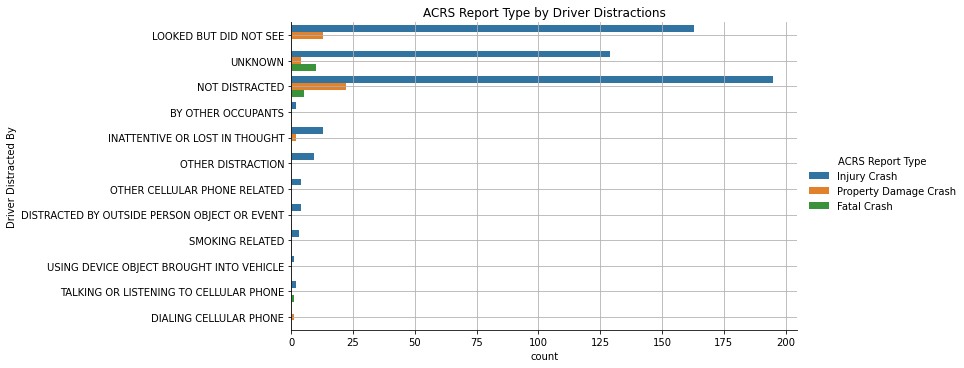

In [14]:
# Bar Graph to count driver distractions

sns.catplot(data=driver_distraction_df,y='Driver Distracted By',hue='ACRS Report Type',kind='count',aspect=60/25)
plt.grid()
plt.title("ACRS Report Type by Driver Distractions");
# plt.savefig("images/Driver_Distractions.png")

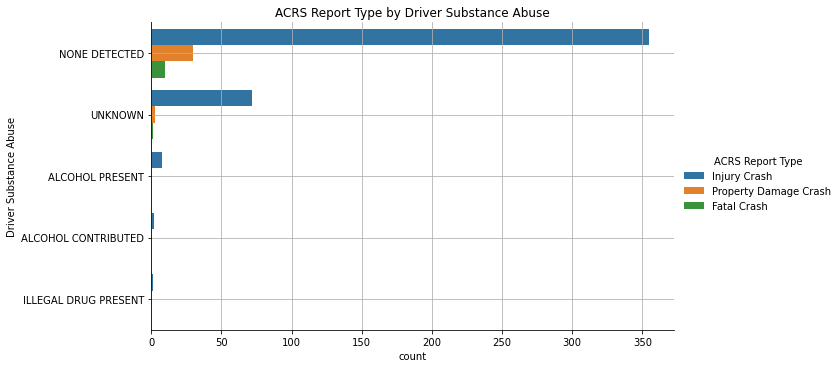

In [15]:
# Graph to viewsubstance abuse with ACRS report type

sns.catplot(data=driver_distraction_df,y='Driver Substance Abuse',hue='ACRS Report Type',kind='count',aspect=30/15)
plt.grid()
plt.title("ACRS Report Type by Driver Substance Abuse");
# plt.savefig("images/Driver_Substance_Abuse.png")

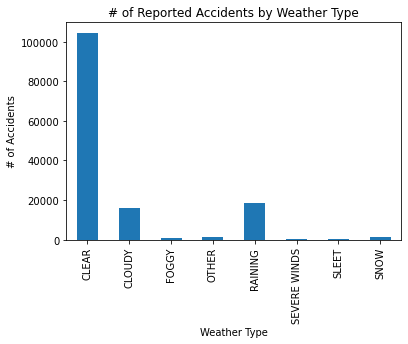

In [16]:
#Graph1: Raw Counts of Reported Accidents by Weather Type
df_county_weather = df_county[df_county['Weather_x'].notna()]
weatherGroups = df_county_weather.groupby("Weather_x")
weather_Reports = weatherGroups['Report Number'].count()

chart1 = weather_Reports.plot(kind="bar", title="Accidents by Weather Type")
chart1.set_xlabel("Weather Type")
chart1.set_ylabel("# of Accidents")
chart1.set_title("# of Reported Accidents by Weather Type");

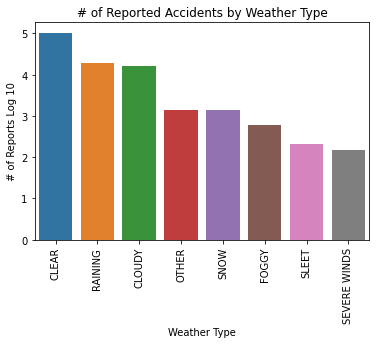

In [17]:
#Log Version of graph1
x1 = df_county['Weather_x'].value_counts().index
y1 = np.log10(df_county['Weather_x'].value_counts().values)
chart = sns.barplot(x=x1,y=y1)
plt.xticks(rotation=90)
plt.xlabel("Weather Type")
plt.ylabel("# of Reports Log 10")
plt.title("# of Reported Accidents by Weather Type");

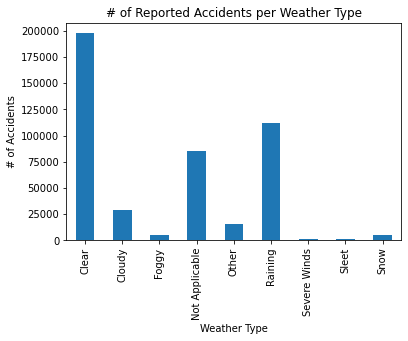

In [18]:
#Graph 2: Raw Counts of Reported Accidents by Weather Type (State Data)
df_state_weather = df_state[df_state['WEATHER_DESC'].notna()]
stateWeather = df_state_weather.groupby("WEATHER_DESC")
stateWeather_Reports = stateWeather['REPORT_NO'].count()

chart1 = stateWeather_Reports.plot(kind="bar", title="Accidents by Weather Type")
chart1.set_xlabel("Weather Type")
chart1.set_ylabel("# of Accidents")
chart1.set_title("# of Reported Accidents per Weather Type");

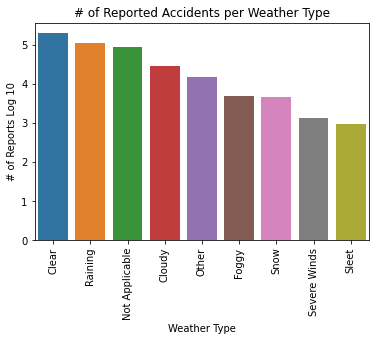

In [19]:
#Log Version of Graph 2
x2 = df_state['WEATHER_DESC'].value_counts().index
y2 = np.log10(df_state['WEATHER_DESC'].value_counts().values)
chart = sns.barplot(x=x2,y=y2)
plt.xticks(rotation=90)
plt.xlabel("Weather Type")
plt.ylabel("# of Reports Log 10")
plt.title("# of Reported Accidents per Weather Type");

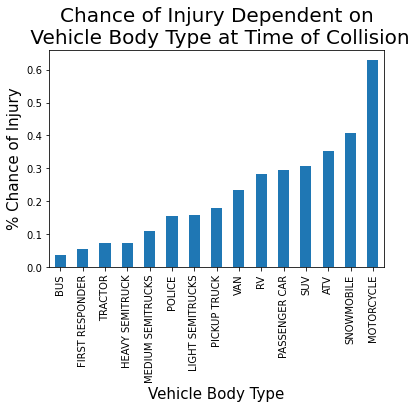

In [20]:
first_x_vals = df_county.groupby('Simple Vehicle Body Type')['Numeric Severity'].mean().sort_values()[:-1]
last_x_vals =  pd.Series(df_county.groupby('Simple Vehicle Body Type')['Numeric Severity'].mean().sort_values()[-1]-1).rename({0:"MOTORCYCLE"})
last_x_vals.name = "Numeric Severity"
first_x_vals.append(last_x_vals).plot.bar()
plt.title('Chance of Injury Dependent on\n Vehicle Body Type at Time of Collision', size=20)
plt.ylabel('% Chance of Injury', size = 15)
plt.xlabel("Vehicle Body Type", size = 15);

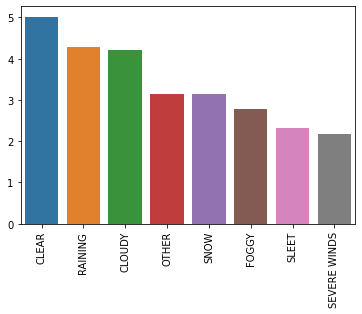

In [21]:
x = df_county['Weather_x'].value_counts().index
y = np.log10(df_county['Weather_x'].value_counts().values)
sns.barplot(x,y)
plt.xticks(rotation=90);

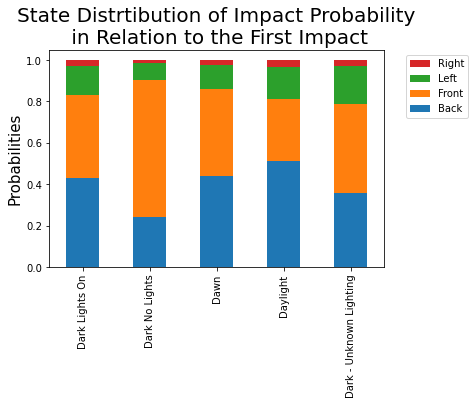

In [22]:
df_state['First Impact Simple'] = df_state['COLLISION_TYPE_DESC'].replace({"Same Direction Rear End":"Back", "Single Vehicle":"Front", "Same Movement Angle":"Back", "Same Direction Sideswipe":"Left", "Head On Left Turn":"Front", "Head On":"Front", "Same Direction Right Turn":"Right", "Same Direction Left Turn":"Left", "Opposite Direction Sideswipe":"Left", "Same Direction Rear End Left Turn":"Back", "Angle Meets Left Turn":"Left", "Same Direction Rear End Right Turn":"Back", "Same Direction Both Left Turn":"Left", "Angle Meets Right Turn":"Right", "Angle Meets Left Turn Head On":"Front", "Opposite Direction Both Left Turn":"Left"})
df_state = df_state[df_state['First Impact Simple'] != "Unknown"]
df_state = df_state[df_state['First Impact Simple'] != "Not Applicable"]
df_state = df_state[df_state['First Impact Simple'] != "Other"]

movementImpact = pd.crosstab(df_state['LIGHT_DESC'], df_state['First Impact Simple'])
movementImpact = movementImpact.div(df_state['LIGHT_DESC'].value_counts(), axis=0)
# reorder from least to most severe
movementImpact.iloc[[1,2,3,4,0]].plot.bar(stacked=True)
plt.title('State Distrtibution of Impact Probability\n in Relation to the First Impact', size=20)
plt.xticks(rotation = 90)
plt.ylabel('Probabilities', size=15)
current_handles, curr_labels = plt.gca().get_legend_handles_labels()
reversed_handles = reversed(current_handles)
reverse_labels = reversed(curr_labels)
plt.legend(reversed_handles, reverse_labels, bbox_to_anchor=(1.05, 1.0), loc='upper left');

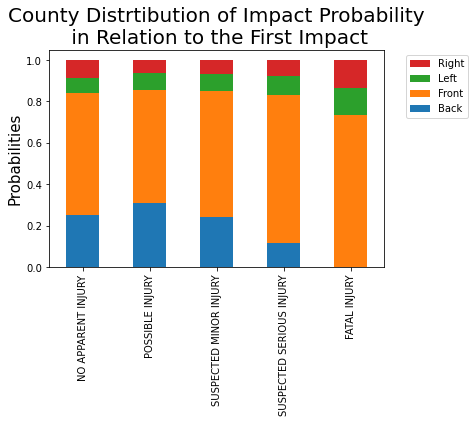

In [23]:
# Replace to simple impact locations
df_county['First Impact Simple'] = df_county['Vehicle First Impact Location'].replace({'ELEVEN OCLOCK': "Front", 'TWELVE OCLOCK': "Front", 'ONE OCLOCK': "Front", 'TWO OCLOCK': "Right", 'THREE OCLOCK': "Right", 'FOUR OCLOCK': "Right", 'FIVE OCLOCK': "Back", 'SIX OCLOCK': "Back", 'SEVEN OCLOCK': "Back", 'EIGHT OCLOCK': "Left", 'NINE OCLOCK': "Left", 'TEN OCLOCK': "Left", 'ROOF TOP': "Top", 'UNDERSIDE': "Bottom", 'NON-COLLISION': "No Collision",'UNKNOWK': "Unknown"})
# We will drop these values because they are unusual to compare with collisions 
df_county.drop(df_county.index[df_county['First Impact Simple'] == 'UNKNOWN'], inplace=True)
df_county.drop(df_county.index[df_county['First Impact Simple'] == 'Top'], inplace=True)
df_county.drop(df_county.index[df_county['First Impact Simple'] == 'Bottom'], inplace=True)
df_county.drop(df_county.index[df_county['First Impact Simple'] == 'No Collision'], inplace = True)
# Create cross tab chart 
movementImpact = pd.crosstab(df_county['Injury Severity_x'], df_county['First Impact Simple'])
movementImpact = movementImpact.div(df_county['Injury Severity_x'].value_counts(), axis=0)
# reorder from least to most severe
movementImpact.iloc[[1,2,3,4,0]].plot.bar(stacked=True)
plt.title('County Distrtibution of Impact Probability\n in Relation to the First Impact', size=20)
plt.xticks(rotation = 90)
plt.ylabel('Probabilities', size=15)
current_handles, curr_labels = plt.gca().get_legend_handles_labels()
reversed_handles = reversed(current_handles)
reverse_labels = reversed(curr_labels)
plt.legend(reversed_handles, reverse_labels, bbox_to_anchor=(1.05, 1.0), loc='upper left');

In [24]:
## TODO


# What effect does weather have on injury severity
# df_county['Weather_x'].value_counts().plot.bar()
# sns.barplot(x="Weather_x", y="Vehicle Year", data=df_county, palette="rainbow", hue="Injury Severity_x")
# sns.catplot(x="Numeric Severity", y="Weather_x", hue="Injury Severity_x", kind='bar', data=df_county, aspect=12/8.2)
# df_county['Weather_x'].value_counts()
# plt.legend(bbox_to_anchor=(1.6, 1.0),loc="upper right")
# plt.ylabel("Weather", size=14)
# plt.xlabel("Numeric Severity", size=14)
# plt.title("Injury Severity given the Weather", size=17);

## Conclusion